# TimeRNN
- TimeRNNはT個のRNNレイヤを連結したネットワークである。
- 誤差逆伝播についての特徴を纏めると
  - 出力が2つに分岐しているため， 逆伝播では各勾配が合算されて伝わる（$dh_t (dy_t) + dh_{next}$）
  - 複数のRNNレイヤがあり，それらのRNNレイヤは同じ重みを使用しているため，最終的な重みの勾配は各RNNレイヤの重みの勾配を足し合わせたものになる



In [ ]:
# 参考: https://github.com/oreilly-japan/deep-learning-from-scratch-2/tree/master

import numpy as np

# 時系列としてレイヤーが並んでいないタイプのRNN
class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b] # それぞれの重みとバイアスをリストとして渡される
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b
        h_next = np.tanh(t)

        self.cache = (x, h_prev, h_next) # 入力，隠れ層への入力，出力　をキャッシュしておく
        return h_next

    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache

        dt = dh_next * (1 - h_next ** 2) # tanhの微分
        db = np.sum(dt, axis=0)
        dWh = np.dot(h_prev.T, dt)
        dh_prev = np.dot(dt, Wh.T)
        dWx = np.dot(x.T, dt) # 入力値×流れてきた誤差，dtが時系列t毎に後のレイヤから流れてきた誤差の違いにより値が異なる
        dx = np.dot(dt, Wx.T)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        return dx, dh_prev

# 時系列としてレイヤー並んでいるタイプのRNN
class TimeRNN:
    # statefulがTrueのときは隠れ状態を維持するようになる。
    # つまり，どんなに長い時系列データであったもTime RNNレイヤの
    # 順伝播を断ち切ることなく伝播させる（長い時系列データを処理するときは隠れ状態を維持する必要がある）
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.dh = None, None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h) # バッチサイズ, T個分の時系列, 入力ベクトルの次元数
            hs[:, t, :] = self.h
            self.layers.append(layer)

        return hs

    # RNN例やの順伝播では出力が2つに分岐しているため，
    # 逆伝播では各勾配が合算されて伝わる（dh_t+dh_next）
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape

        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)
            dxs[:, t, :] = dx

            # 複数のRNNレイヤがあり，それらのRNNレイヤは同じ重みを使用しているため，
            # 最終的な重みの勾配は各RNNレイヤの重みの勾配を足し合わせたものになる
            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        # 最終的に各レイヤ毎の重みを保存
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh

        return dxs

    def set_state(self, h):
        self.h = h

    def reset_state(self):
        self.h = None

# Q2
- シンプルな再帰型ニューラルネットワークのforward
- 本実装では活性化関数とバイアスは省略している
- 時系列方向に2層のRNN

In [ ]:
import numpy as np

class RNN:
    def __init__(self, Wx, Wh, h0):
        """
        Wx : 入力xにかかる重み（1,隠れ層のノード数）
        Wh : 1時刻前のhにかかる重み（隠れ層のノード数, 隠れ層のノード数）
        h0 : 隠れ層の初期値（1,隠れ層のノード数）
        """

        # パラメータのリスト
        # 入力層の重み，中間層の重み
        self.params = [Wx, Wh]

        # 隠れ層の初期値を設定
        # 初期値はh0
        self.h_prev = h0

    def forward(self, x):
        """
        順伝播計算
        x : 入力（データ数,1）
        """
        Wx, Wh = self.params
        h_prev = self.h_prev

        t = np.dot(h_prev, Wh) + np.dot(x, Wx)

        # 活性化関数は恒等写像関数とする
        h_next = t

        # 隠れ層の状態の保存
        self.h_prev = h_next

        return h_next

    
if __name__=="__main__":
    Wx = np.arange(1*5).reshape(1, 5)
    print("Wx\n", Wx)
    Wh = np.arange(5*5).reshape(5, 5)
    print("Wh\n", Wh)    
    h0 = np.arange(5).reshape(1, 5)
    print("h0\n", h0) 
    
    rnn = RNN(Wx, Wh, h0)
    
    x = np.arange(3*1).reshape(3, 1)
    print("x\n", x)
    
    h_next = rnn.forward(x)
    print("h_next\n", h_next)


# Q4
- シンプルなLSTMレイヤのforward

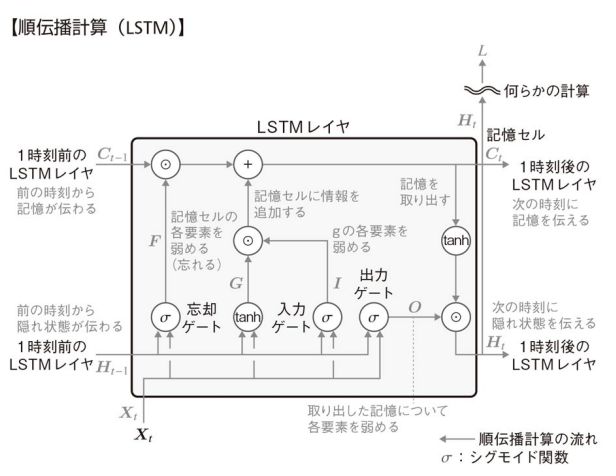

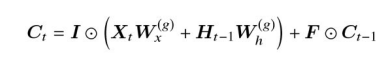

## 覗き穴結合(補足)
以上の図のようにLSTMではG，忘却ゲートの値F，入力ゲートの値I，出力ゲートの値Oを決める際に以下のように$X_t$,$H_{t-1}$,$B$から算出していた。

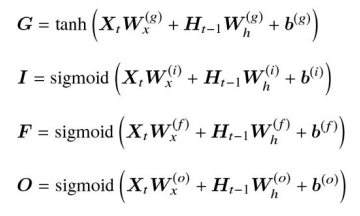

のぞき穴結合では，以上式に加えて記憶セルの状態$C_{t-1}$の線形形式を用いてG，忘却ゲートの値F，入力ゲートの値I，出力ゲートの値Oを求める（以下覗き穴結合）。

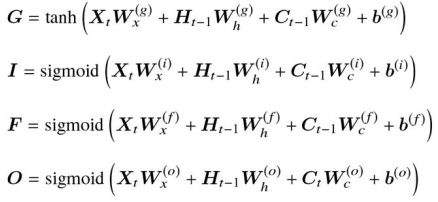

この時，$C$と$W$の計算は行列積にする場合やアダマール積で計算する場合もある。

In [ ]:
import numpy as np

def forward(x, h_prev, c_prev, Wx, Wh, b):
    """
    順伝播計算
    x: 入力 (データ数, 特徴量の数)
    h_prev: 前時刻の隠れ層の出力 （データ数, 隠れ層のノード数）
    c_prev: 前時刻のメモリの状態 （データ数, 隠れ層のノード数）
    Wx: 入力x用の重みパラメータ （特徴量の数, 4×隠れ層のノード数）
    Wh: 隠れ状態h用の重みパラメータ（隠れ層のノード数, 4×隠れ層のノード数）
    b: バイアス （4×隠れ層のノード数）
    """

    N, H = h_prev.shape

    # 計算の高速化のために重みを[特徴量の数, 4×隠れノード数]としている。
    # 隠れノード数を4を掛けていることによって以下式が一括で行列演算できる且つ
    # 次のフェーズでf, g, i, oに対応する部分を取り出せば良いだけになる
    A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b

    # 先の計算で効率化するために一括で行列演算した後の結果を取り出し。
    f = A[:, :H]
    g = A[:, H:2*H]
    i = A[:, 2*H:3*H]
    o = A[:, 3*H:]

    f = sigmoid(f)
    g = np.tanh(g)
    i = sigmoid(i)
    o = sigmoid(o)

    print(f.shape, c_prev.shape, g.shape, i.shape)
    c_next = f * c_prev + g * i
    h_next = o * np.tanh (c_next)

    return h_next, c_next


def sigmoid(x):
    return 1 / (1 + np.exp(-x))
    
    
if __name__=="__main__":
    N = 2
    D = 3
    H = 4
    x = np.random.randn(N, D)
    print("x\n", x)
    
    h_prev = np.random.randn(N, H)
    print("h_prev\n", h_prev)
    
    c_prev = np.random.randn(N, H)
    print("c_prev\n", c_prev)
    
    Wx = np.random.randn(D, 4*H)
    print("Wx\n", Wx)
    
    Wh = np.random.randn(H, 4*H)
    print("Wh\n", Wh)   
    
    b = np.random.randn(4*H)
    print("b\n", b) 
    
    h_next, c_next = forward(x, h_prev, c_prev, Wx, Wh, b)
    print("h_next\n", h_next)
    print("c_next\n", c_next)    